In [1]:
import requests
import json 
from bs4 import BeautifulSoup as bs
from tqdm import tqdm

urls = json.load(open("pandas_apis.json"))
data_frame_url = urls["df"]

In [2]:
import os 

if not os.path.exists("api_details"):
    os.mkdir("api_details")

In [3]:
import re
def get_details_about_apis(which_type_of_url, _url):
    invalid_count = 0
    page = requests.get(_url)
    soup = bs(page.content, 'html.parser')
    all_about_apis = []
    codes = soup.find_all("code", {"class": "xref py py-obj docutils literal notranslate"})
    for code in codes:
        api_name = code.find("span").text
        if "." in api_name:
            api_name = api_name[api_name.index(".") + 1:]
        documentation = list(code.parent.parent.parent.parent.children)[2].find("p").text
        try:
            category = code.parent.parent.parent.parent.parent.parent.parent.find("h2").text[:-1]
        except:
            category = which_type_of_url
        if len(api_name.strip()) == 0 or len(documentation.strip()) == 0 or len(category.strip()) == 0:
            invalid_count += 1
            continue
        all_about_apis.append({
            "api": re.sub(",", " ", str(api_name.encode("ascii", errors="ignore").decode())),
            "doc": re.sub(",", " ", str(documentation.encode("ascii", errors="ignore").decode())),
            "category": re.sub(",", " ", str(category.encode("ascii", errors="ignore").decode()))
        })
    print(invalid_count)
    return all_about_apis
    
all_about_dataframe_apis = get_details_about_apis("dataframe", data_frame_url)
fp = open("api_details/all_about_dataframe_apis.json", "w")
json.dump(all_about_dataframe_apis, fp, indent=4)
fp.close()

1


In [4]:
all_apis_with_all_details = []
for which in urls.keys():
    all_apis_with_all_details.extend(get_details_about_apis(which, urls[which]))

2
1
3
1
31
12
2


In [5]:
import csv
 
data_file = open('api_details/data_frame_api_details.csv', 'w')
keys = all_about_dataframe_apis[0].keys()
data_file.write("api,category,doc\n")
count = 0
for data in all_about_dataframe_apis:
    data_file.write(data["api"] + "," + data["category"] + "," + data["doc"] + "\n")
 
data_file.close()

In [6]:
import csv
 
data_file = open('api_details/pandas_api_details.csv', 'w')
keys = all_apis_with_all_details[0].keys()
data_file.write("api,category,doc\n")
count = 0
for data in all_apis_with_all_details:
    data_file.write(data["api"] + "," + data["category"] + "," + data["doc"] + "\n")
 
data_file.close()

In [7]:
taken_answer_dir = "25_K_Examples"
all_taken_answers = []
for part in range(1, 4):
    taken_answers = json.load(
        open(
            os.path.join(
                taken_answer_dir, 
                f"part-{part}-output/taken_answers_with_all_details.json"
            )
        )
    )
    for answer in taken_answers:
        all_taken_answers.append(answer["formatted_input"])

print(len(all_taken_answers))
    

659


In [8]:
import numpy as np 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

def remove_punc(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in symbols:
        data = np.char.replace(data, i, ' ')
    return str(data)

def remove_single_char(data):
    new_text = ""
    words = data.split()
    for w in words:
        if len(w) > 1:
           new_text = new_text + " " + w
    return new_text

def remove_stopword(data):
    stop_words = stopwords.words("english")
    words = data.split()
    new_text = ""
    for word in words:
        if word not in stop_words:
            new_text = new_text + " " + word
    return new_text

def stem(data):
    ps = PorterStemmer()
    words = data.split()
    new_text = ""
    for w in words:
        new_text += (" " + ps.stem(w))
    return new_text

def lematize(data):
    ps = WordNetLemmatizer()
    words = data.split()
    new_text = ""
    for w in words:
        new_text += (" " + ps.lemmatize(w))
    return new_text

def dataframe(data):
    words = data.split()
    new_text = ""
    for word in words:
        if word == "df" or word == "dataframe":
            word = "data frame"
        new_text += (" " + word)
    return new_text

def preprocess(data):
    words = word_tokenize(data)
    data = " ".join(words)
    data = np.char.lower(data)
    data = remove_punc(data)
    data = str(np.char.replace(data, "'", ""))
    data = remove_single_char(data)
    data = remove_stopword(data)
    data = stem(data)
    data = lematize(data)
    data = dataframe(data)
    data = remove_punc(data)
    return data


# Only Title

In [9]:
sentences = []
apis = []
for point in all_about_dataframe_apis:
    sentences.append(preprocess(point["doc"]))
    apis.append(point["api"])

for answer in all_taken_answers:
    ques = answer["question"]
    title = ques["title"]
    sentences.append(preprocess(title))
    pass

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sentences)
print(X.shape)

documentation_features = X[:len(all_about_dataframe_apis), :]
example_features = X[len(all_about_dataframe_apis):, :]
print(documentation_features.shape, example_features.shape)

from sklearn.metrics.pairwise import cosine_similarity
similarity_results = cosine_similarity(documentation_features, example_features)
print(similarity_results.shape)

(883, 814)
(224, 814) (659, 814)
(224, 659)


## From example perspective 
### Total points = len(examples)

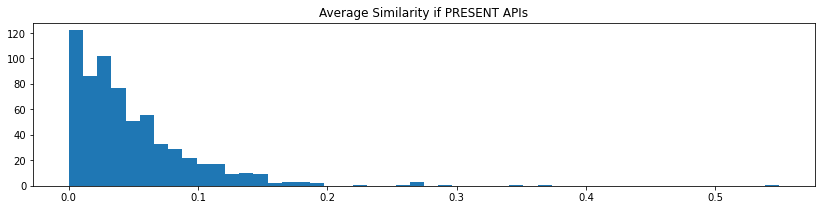

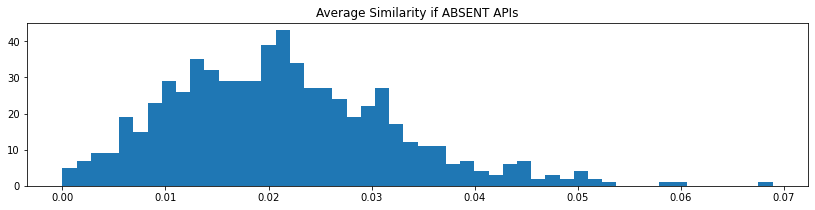

In [33]:
overlap_p_ques = []
overlap_a_ques = []
for exidx, example in enumerate(all_taken_answers):
    code = example["answer"]["code"]
    present_scores, absent_scores = [], []
    for api_idx, api in enumerate(apis):
        api = str(api)  
        found = False
        for c in code:
            if api in c:
                found = True
                break
        if found:
            present_scores.append(similarity_results[api_idx, exidx])
        else:
            absent_scores.append(similarity_results[api_idx, exidx])
    overlap_p_ques.append(
        np.mean(present_scores) if len(present_scores) > 0 else 0.0
    )
    overlap_a_ques.append(
        np.mean(absent_scores) if len(absent_scores) > 0 else 0.0,
    )

import matplotlib.pyplot as plt
plt.figure(figsize=(14,3))
plt.hist(overlap_p_ques, label="Present", bins=50)
plt.title("Average Similarity if PRESENT APIs")
plt.show()
plt.figure(figsize=(14, 3))
plt.hist(overlap_a_ques, label="Absent", bins=50)
plt.title("Average Similarity if ABSENT APIs")
plt.show()

## From API perspective
### Total points = len(apis)

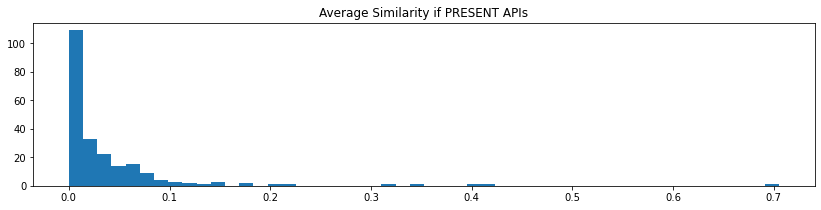

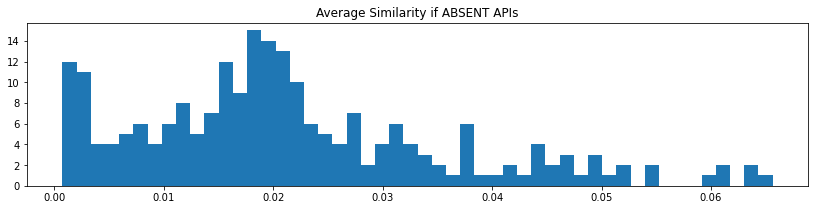

In [34]:
overlap_p_api = []
overlap_a_api = []
for api_idx, api in enumerate(apis):
    api = str(api)  
    present_scores, absent_scores = [], []
    for exidx, example in enumerate(all_taken_answers):
        code = example["answer"]["code"]
        found = False
        for c in code:
            if api in c:
                found = True
                break
        if found:
            present_scores.append(similarity_results[api_idx, exidx])
        else:
            absent_scores.append(similarity_results[api_idx, exidx])
    overlap_p_api.append(
        np.mean(present_scores) if len(present_scores) > 0 else 0.0
    )
    overlap_a_api.append(
        np.mean(absent_scores) if len(absent_scores) > 0 else 0.0,
    )

import matplotlib.pyplot as plt
plt.figure(figsize=(14,3))
plt.hist(overlap_p_api, label="Present", bins=50)
plt.title("Average Similarity if PRESENT APIs")
plt.show()
plt.figure(figsize=(14, 3))
plt.hist(overlap_a_api, label="Absent", bins=50)
plt.title("Average Similarity if ABSENT APIs")
plt.show()

## From Both Perspective
### Total points = len(examples) * len(apis)

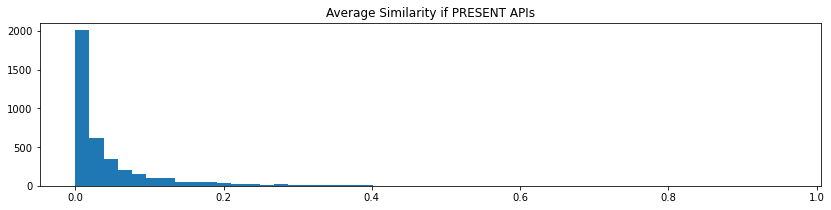

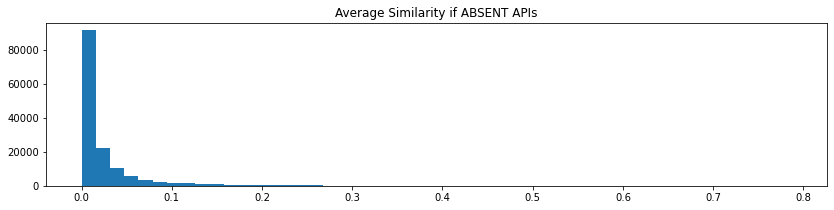

In [35]:
overlap_p_both = []
overlap_a_both = []
for api_idx, api in enumerate(apis):
    api = str(api)  
    for exidx, example in enumerate(all_taken_answers):
        code = example["answer"]["code"]
        found = False
        for c in code:
            if api in c:
                found = True
                break
        if found:
            overlap_p_both.append(similarity_results[api_idx, exidx])
        else:
            overlap_a_both.append(similarity_results[api_idx, exidx])

import matplotlib.pyplot as plt
plt.figure(figsize=(14,3))
plt.hist(overlap_p_both, label="Present", bins=50)
plt.title("Average Similarity if PRESENT APIs")
plt.show()
plt.figure(figsize=(14, 3))
plt.hist(overlap_a_both, label="Absent", bins=50)
plt.title("Average Similarity if ABSENT APIs")
plt.show()